---

## Universidad de Costa Rica
### Escuela de Ingeniería Eléctrica
#### IE0405 - Modelos Probabilísticos de Señales y Sistemas

---

* Estudiante: **Miguel Zamora Torres**
* Carné: **B78542**
* Grupo: **2**

---
# `P4` - *Modulación digital IQ*

---



## 4. - Asignaciones del proyecto

### 4.1. - Modulación 16-QAM

* (50%) Realice una simulación del sistema de comunicaciones como en la sección 3.2., pero utilizando una modulación **16-QAM** en lugar de una modulación BPSK. Deben mostrarse las imágenes enviadas y recuperadas y las formas de onda.

In [1]:
from PIL import Image
import numpy as np

def fuente_info(imagen):
    '''Una función que simula una fuente de
    información al importar una imagen y 
    retornar un vector de NumPy con las 
    dimensiones de la imagen, incluidos los
    canales RGB: alto x largo x 3 canales

    :param imagen: Una imagen en formato JPG
    :return: un vector de pixeles
    '''
    img = Image.open(imagen)
    
    return np.array(img)

In [2]:
import numpy as np

def rgb_a_bit(array_imagen):
    '''Convierte los pixeles de base 
    decimal (de 0 a 255) a binaria 
    (de 00000000 a 11111111).

    :param imagen: array de una imagen 
    :return: Un vector de (1 x k) bits 'int'
    '''
    # Obtener las dimensiones de la imagen
    x, y, z = array_imagen.shape
    
    # Número total de elementos (pixeles x canales)
    n_elementos = x * y * z

    # Convertir la imagen a un vector unidimensional de n_elementos
    pixeles = np.reshape(array_imagen, n_elementos)

    # Convertir los canales a base 2
    bits = [format(pixel, '08b') for pixel in pixeles]
    bits_Rx = np.array(list(''.join(bits)))
    
    return bits_Rx.astype(int)

In [28]:
import numpy as np

def modulador(bits, fc, mpp):

    # 1. Parámetros de la 'señal' de información (bits)
    N = len(bits) # Cantidad de bits

    # 2. Construyendo un periodo de la señal portadora c(t)
    Tc = 1 / fc  # periodo [s]
    t_periodo = np.linspace(0, Tc, mpp)  # mpp: muestras por período

    portadora_Q = np.sin(2*np.pi*fc*t_periodo)
    portadora_I = np.cos(2*np.pi*fc*t_periodo)
    
    portadora = portadora_I + portadora_Q

    # 3. Inicializar la señal modulada s(t)
    t_simulacion = np.linspace(0, N*Tc//4, N*mpp//4) 
    
    senal_Tx = np.zeros(len(t_simulacion))
    moduladora = np.zeros(len(t_simulacion))  # (opcional) señal de bits
    
    # 4. Asignar las formas de onda según los bits (BPSK)   
    j = 0
    for i in range(0, len(bits), 4):
        
        simb_1 = bits[i]*10 + bits[i+1]
        simb_2 = bits[i+2]*10 + bits[i+3]
        
        if simb_1 == 0:
            senal_Tx[j*mpp : (j+1)*mpp] += portadora_I * -3
            moduladora[j*mpp : (j+1)*mpp] += 0
        elif simb_1 == 1:
            senal_Tx[j*mpp : (j+1)*mpp] += portadora_I * -1
            moduladora[i*mpp : (i+1)*mpp] += 4
        elif simb_1 == 10:
            senal_Tx[j*mpp : (j+1)*mpp] += portadora_I
            moduladora[j*mpp : (j+1)*mpp] += 8
        elif simb_1 == 11:
            senal_Tx[j*mpp : (j+1)*mpp] += portadora_I * 3
            moduladora[j*mpp : (j+1)*mpp] += 12

        if simb_2 == 0:
            senal_Tx[j*mpp : (j+1)*mpp] += portadora_Q * 3
            moduladora[j*mpp : (j+1)*mpp] += 0
        elif simb_2 == 1:
            senal_Tx[j*mpp : (j+1)*mpp] += portadora_Q
            moduladora[j*mpp : (j+1)*mpp] += 1
        elif simb_2 == 10:
            senal_Tx[j*mpp : (j+1)*mpp] += portadora_Q * -1
            moduladora[j*mpp : (j+1)*mpp] += 2
        elif simb_2 == 11:
            senal_Tx[j*mpp : (j+1)*mpp] += portadora_Q * -3
            moduladora[j*mpp : (j+1)*mpp] += 3
        j += 1

    # 5. Calcular la potencia promedio de la señal modulada
    tau = 0.5

    Pm = (1 / (N*Tc)) * np.trapz(pow(senal_Tx, 2), t_simulacion)
    Promedio_Temporal = (1 / (N*Tc)) * np.trapz(senal_Tx, t_simulacion)
    Autocorrelacion_Temporal = (1 / (N*Tc)) * np.trapz(senal_Tx*(senal_Tx+tau), t_simulacion)
    print('Promedio_Temporal:', Promedio_Temporal)
    print('Autocorrelacion_Temporal:', Autocorrelacion_Temporal)
   
    return senal_Tx, Pm, portadora, moduladora 

In [29]:
import numpy as np

def canal_ruidoso(senal_Tx, Pm, SNR):

    # Potencia del ruido generado por el canal
    Pn = Pm / pow(10, SNR/10)

    # Generando ruido auditivo blanco gaussiano (potencia = varianza)
    ruido = np.random.normal(0, np.sqrt(Pn), senal_Tx.shape)

    # Señal distorsionada por el canal ruidoso
    senal_Rx = senal_Tx + ruido

    return senal_Rx

In [30]:
import numpy as np

def demodulador(senal_Rx, portadora, mpp):

    # Cantidad de muestras en senal_Rx
    M = len(senal_Rx)

    N = int(M / mpp)
    
    # Vector para bits obtenidos por la demodulación
    bits_Rx = np.zeros(N*4)

    # Vector para la señal demodulada
    senal_demodulada = np.zeros(senal_Rx.shape)

    # Pseudo-energía de un período de la portadora
    Es = np.sum(portadora * portadora)

    # Demodulación
    for i in range(N):
        # Producto interno de dos funciones
        producto = senal_Rx[i*mpp : (i+1)*mpp] * portadora
        
        Ep = np.sum(producto) 
        senal_demodulada[i*mpp : (i+1)*mpp] = producto
        
        # Criterio de decisión por detección de energía
        if((Ep < -2.5) & (Ep > -3.5)):
            bits_Rx[4*i] = 0
            bits_Rx[4*i+1] = 0
            bits_Rx[4*i+2] = 0
            bits_Rx[4*i+3] = 0
        elif((Ep < -21.5) & (Ep > -22.5)):
            bits_Rx[4*i] = 0
            bits_Rx[4*i+1] = 0
            bits_Rx[4*i+2] = 0
            bits_Rx[4*i+3] = 1
        elif((Ep < -40.5) & (Ep > -41.5)):
            bits_Rx[4*i] = 0
            bits_Rx[4*i+1] = 0
            bits_Rx[4*i+2] = 1
            bits_Rx[4*i+3] = 0
        elif((Ep < -59.5) & (Ep > -60.5)):
            bits_Rx[4*i] = 0
            bits_Rx[4*i+1] = 0
            bits_Rx[4*i+2] = 1
            bits_Rx[4*i+3] = 1
        elif((Ep > 17.5) & (Ep < 18.5)):
            bits_Rx[4*i] = 0
            bits_Rx[4*i+1] = 1
            bits_Rx[4*i+2] = 0
            bits_Rx[4*i+3] = 0
        elif((Ep < -0.5) & (Ep > -1.5)):
            bits_Rx[4*i] = 0
            bits_Rx[4*i+1] = 1
            bits_Rx[4*i+2] = 0
            bits_Rx[4*i+3] = 1
        elif((Ep < -19.5) & (Ep > -20.5)):
            bits_Rx[4*i] = 0
            bits_Rx[4*i+1] = 1
            bits_Rx[4*i+2] = 1
            bits_Rx[4*i+3] = 0
        elif((Ep < -38.5) & (Ep > -39.5)):
            bits_Rx[4*i] = 0
            bits_Rx[4*i+1] = 1
            bits_Rx[4*i+2] = 1
            bits_Rx[4*i+3] = 1
        elif((Ep > 38.5) & (Ep < 39.5)):
            bits_Rx[4*i] = 1
            bits_Rx[4*i+1] = 0
            bits_Rx[4*i+2] = 0
            bits_Rx[4*i+3] = 0
        elif((Ep > 19.5) & (Ep < 20.5)):
            bits_Rx[4*i] = 1
            bits_Rx[4*i+1] = 0
            bits_Rx[4*i+2] = 0
            bits_Rx[4*i+3] = 1
        elif((Ep > 0.5) & (Ep < 1.5)):
            bits_Rx[4*i] = 1
            bits_Rx[4*i+1] = 0
            bits_Rx[4*i+2] = 1
            bits_Rx[4*i+3] = 0
        elif((Ep < -17.5) & (Ep > -18.5)):
            bits_Rx[4*i] = 1
            bits_Rx[4*i+1] = 0
            bits_Rx[4*i+2] = 1
            bits_Rx[4*i+3] = 1
        elif((Ep > 59.5) & (Ep < 60.5)):
            bits_Rx[4*i] = 1
            bits_Rx[4*i+1] = 1
            bits_Rx[4*i+2] = 0
            bits_Rx[4*i+3] = 0
        elif((Ep > 40.5) & (Ep < 41.5)):
            bits_Rx[4*i] = 1
            bits_Rx[4*i+1] = 1
            bits_Rx[4*i+2] = 0
            bits_Rx[4*i+3] = 1
        elif((Ep > 21.5) & (Ep < 22.5)):
            bits_Rx[4*i] = 1
            bits_Rx[4*i+1] = 1
            bits_Rx[4*i+2] = 1
            bits_Rx[4*i+3] = 0    
        else:
            bits_Rx[4*i] = 1
            bits_Rx[4*i+1] = 1
            bits_Rx[4*i+2] = 1
            bits_Rx[4*i+3] = 1
        

    return bits_Rx.astype(int), senal_demodulada

In [31]:
import numpy as np

def bits_a_rgb(bits_Rx, dimensiones):

    # Cantidad de bits
    N = len(bits_Rx)

    # Se reconstruyen los canales RGB
    bits = np.split(bits_Rx, N / 8)

    # Se decofican los canales:
    canales = [int(''.join(map(str, canal)), 2) for canal in bits]
    pixeles = np.reshape(canales, dimensiones)

    return pixeles.astype(np.uint8)

bits_Tx: 422928
Promedio_Temporal: 0.0032328643032998564
Autocorrelacion_Temporal: 1.201902658192371
señal tx: 2114640
bits rx: 422928
Duración de la simulación (s):  3.0269062519073486
0 errores, para un BER de 0.0000.


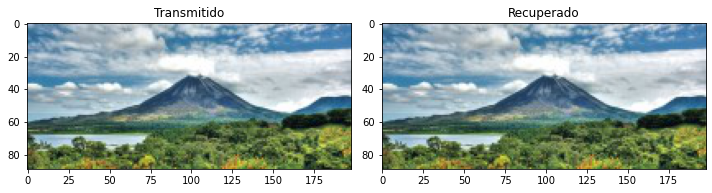

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Parámetros
fc = 5000  # frecuencia de la portadora
mpp = 20   # muestras por periodo de la portadora
SNR = 35  # relación señal-a-ruido del canal

# Iniciar medición del tiempo de simulación
inicio = time.time()

# 1. Importar y convertir la imagen a trasmitir
imagen_Tx = fuente_info('arenal.jpg')

dimensiones = imagen_Tx.shape

# 2. Codificar los pixeles de la imagen
bits_Tx = rgb_a_bit(imagen_Tx)
# bits_Tx = np.array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0 ,1 ,1, 0, 1, 0, 0, 0, 1, 0, 1, 0 ,1, 1, 0, 0, 1, 1, 1, 1, 0,0,0, 1,0,0,1, 1,0,1,0, 1,0,1,1, 1,1,0,0, 1,1,0,1, 1,1,1,0, 1,1,1,1])

print('bits_Tx:', len(bits_Tx))

# 3. Modular la cadena de bits usando el esquema BPSK
senal_Tx, Pm, portadora, moduladora = modulador(bits_Tx, fc, mpp)
print('señal tx:', len(senal_Tx))


# 4. Se transmite la señal modulada, por un canal ruidoso
senal_Rx = canal_ruidoso(senal_Tx, Pm, SNR)
# senal_Rx = senal_Tx

# 5. Se desmodula la señal recibida del canal
bits_Rx, senal_demodulada = demodulador(senal_Rx, portadora, mpp)
print('bits rx:', len(bits_Rx))


# 6. Se visualiza la imagen recibida 
imagen_Rx = bits_a_rgb(bits_Rx, dimensiones)
Fig = plt.figure(figsize=(10,6))

# Cálculo del tiempo de simulación
print('Duración de la simulación (s): ', time.time() - inicio)

# 7. Calcular número de errores
errores = sum(abs(bits_Tx - bits_Rx))
BER = errores/len(bits_Tx)
print('{} errores, para un BER de {:0.4f}.'.format(errores, BER))

# Mostrar imagen transmitida
ax = Fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(imagen_Tx)
ax.set_title('Transmitido')

# Mostrar imagen recuperada
ax = Fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(imagen_Rx)
ax.set_title('Recuperado')
Fig.tight_layout()

plt.imshow(imagen_Rx)

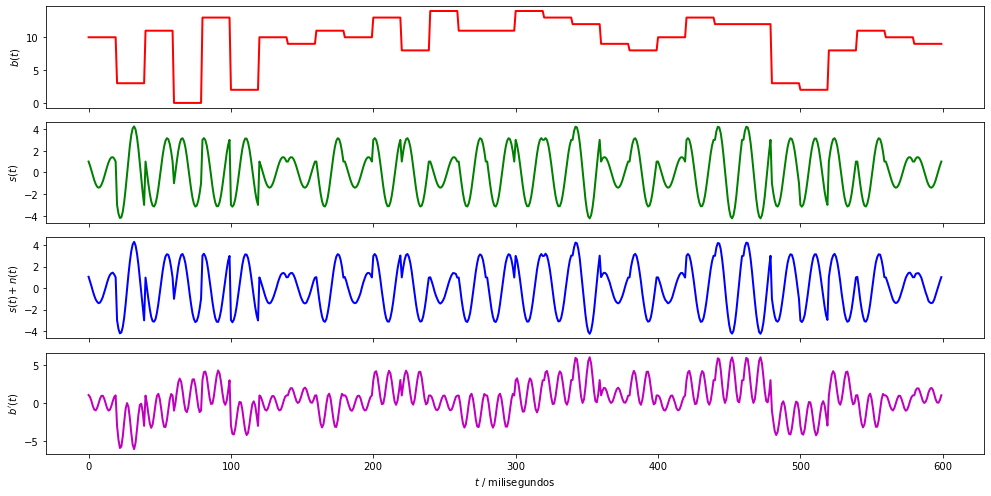

In [8]:
import matplotlib.pyplot as plt

# Visualizar el cambio entre las señales
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, sharex=True, figsize=(14, 7))

# La onda cuadrada moduladora (bits de entrada)
ax1.plot(moduladora[0:600], color='r', lw=2) 
ax1.set_ylabel('$b(t)$')

# La señal modulada por BPSK
ax2.plot(senal_Tx[0:600], color='g', lw=2) 
ax2.set_ylabel('$s(t)$')

# La señal modulada al dejar el canal
ax3.plot(senal_Rx[0:600], color='b', lw=2) 
ax3.set_ylabel('$s(t) + n(t)$')

# La señal demodulada
ax4.plot(senal_demodulada[0:600], color='m', lw=2) 
ax4.set_ylabel('$b^{\prime}(t)$')
ax4.set_xlabel('$t$ / milisegundos')
fig.tight_layout()
plt.show()

### 4.2. - Estacionaridad y ergodicidad

* (30%) Realice pruebas de estacionaridad y ergodicidad a la señal modulada `senal_Tx` y obtenga conclusiones sobre estas.

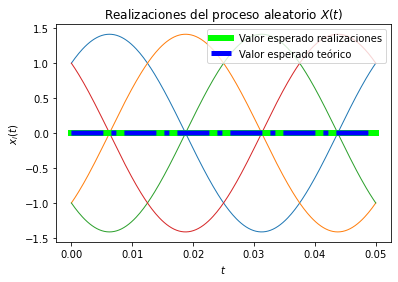

In [18]:
#Parte 4.2
# Se define el tiempo para el análisis (tiempo de muestreo) 
tiempo = np.linspace(0, 0.05 ,250) #250 puntos desde 0 hasta 0.1

# Se crea un vector A donde se contienen los únicos dos valores que puede tomar este
A=[1,-1]


X_t = np.empty((4, len(tiempo)))   

plt.figure()

  #Con este for se obtienen todos los posibles valores para el tiempo en análisis
for i in A:
    s1 = i * np.cos(2*(np.pi)*fc*tiempo) +  i * np.sin(2*(np.pi)*fc*tiempo)
    s2 = -i * np.cos(2*(np.pi)*fc*tiempo) +  i * np.sin(2*(np.pi)*fc*tiempo) 
    
    
    X_t[i,:] = s1
    X_t[i+1,:] = s2
    plt.plot(tiempo,s1, lw=1) #Se obtienen las gráficas para s1 y s2
    plt.plot(tiempo, s2, lw=1)       


P = [np.mean(X_t[:,i]) for i in range(len(tiempo))] #Se obtinene la media
plt.plot(tiempo, P, lw=6,color='lime',label='Valor esperado realizaciones')


Valor_esperado_senal = np.mean(senal_Tx)*tiempo   #Se obtiene la media teórica
plt.plot(tiempo, Valor_esperado_senal, '-.', lw=5,color='b',label='Valor esperado teórico')

#Se grafica
plt.title('Realizaciones del proceso aleatorio $X(t)$')
plt.xlabel('$t$')
plt.ylabel('$x_i(t)$')
plt.legend()
plt.show()

### 4.3. - Densidad espectral de potencia

* (20%) Determine y grafique la densidad espectral de potencia para la señal modulada `senal_Tx`.

\begin{equation}
\displaystyle
\mathcal{S}_{XX}(\omega) = \lim_{T \rightarrow \infty}\frac{E[\vert X_{T}(\omega) \vert^2]}{2T}
\end{equation}

<ipython-input-22-c2db7ccafb68>:4: DeprecationWarning: Using scipy.fft as a function is deprecated and will be removed in SciPy 1.5.0, use scipy.fft.fft instead.
  senal_f = fft(senal_Tx)


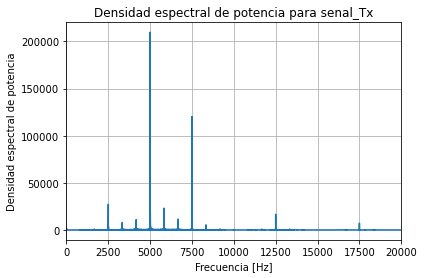

In [22]:
from scipy import fft

# Transformada de Fourier
senal_f = fft(senal_Tx)

# Muestras de la señal
Nm = len(senal_Tx)

# Número de símbolos (198 x 89 x 8 x 3)
Ns = Nm // mpp

# Tiempo del símbolo = periodo de la onda portadora
Tc = 1 / fc

# Tiempo entre muestras (período de muestreo)
Tm = Tc / mpp

# Tiempo de la simulación
T = Ns * Tc

# Espacio de frecuencias
f = np.linspace(0.0, 1.0/(2.0*Tm), Nm//2)

# Gráfica
plt.plot(f, 2.0/Nm * np.power(np.abs(senal_f[0:Nm//2]), 2))
plt.xlim(0, 20000)
plt.grid()
plt.title('Densidad espectral de potencia para senal_Tx') 
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Densidad espectral de potencia')
plt.show()

---

### Universidad de Costa Rica
#### Facultad de Ingeniería
##### Escuela de Ingeniería Eléctrica

---